## Localización de farmacias en Región Metropolitana de Chile usando Geopandas

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

import warnings
warnings.filterwarnings('ignore')

###  1. Carga de datos.

Se trabajará con la base de datos de farmacias existentes a nivel nacional.
La base de datos se encuentra disponible en https://farmanet.minsal.cl/index.php/ws/getLocales

In [2]:
# Recuperación de datos desde página del Minsal.
url="https://farmanet.minsal.cl/index.php/ws/getLocales"
r = requests.request("GET", url)
data=r.text.encode().decode('utf-8-sig')
diccio = json.loads(data)

In [3]:
print(diccio[:3])

[{'fecha': '07-09-20', 'local_id': '1', 'local_nombre': 'CRUZ VERDE ', 'comuna_nombre': 'QUILLOTA', 'localidad_nombre': 'QUILLOTA', 'local_direccion': 'OHIGGINS 195, LOCAL 1', 'funcionamiento_hora_apertura': '08:30:00', 'funcionamiento_hora_cierre': '18:30:00', 'local_telefono': '+56332269467', 'local_lat': '-32.8793428949969', 'local_lng': '-71.2467871500868', 'funcionamiento_dia': 'lunes', 'fk_region': '6', 'fk_comuna': '69', 'fk_localidad': '32'}, {'fecha': '07-09-20', 'local_id': '2', 'local_nombre': 'CRUZ VERDE', 'comuna_nombre': 'LA CALERA', 'localidad_nombre': 'LA CALERA', 'local_direccion': 'J.J. PEREZ 202', 'funcionamiento_hora_apertura': '08:30:00', 'funcionamiento_hora_cierre': '18:30:00', 'local_telefono': '+56332724714', 'local_lat': '-32.788066282624', 'local_lng': '-71.1897310126255', 'funcionamiento_dia': 'lunes', 'fk_region': '6', 'fk_comuna': '56', 'fk_localidad': '12'}, {'fecha': '07-09-20', 'local_id': '3', 'local_nombre': 'CRUZ VERDE', 'comuna_nombre': 'LIMACHE', '

In [4]:
# Generación de DataFrame.
farmacia=pd.DataFrame(diccio)

In [5]:
farmacia.head()

,comuna_nombre,fecha,fk_comuna,fk_localidad,fk_region,funcionamiento_dia,funcionamiento_hora_apertura,funcionamiento_hora_cierre,local_direccion,local_id,local_lat,local_lng,local_nombre,local_telefono,localidad_nombre
0,QUILLOTA,07-09-20,69,32,6,lunes,08:30:00,18:30:00,"OHIGGINS 195, LOCAL 1",1,-32.8793428949969,-71.2467871500868,CRUZ VERDE,+56332269467,QUILLOTA
1,LA CALERA,07-09-20,56,12,6,lunes,08:30:00,18:30:00,J.J. PEREZ 202,2,-32.788066282624,-71.1897310126255,CRUZ VERDE,+56332724714,LA CALERA
2,LIMACHE,07-09-20,59,17,6,lunes,08:30:00,18:30:00,URMENETA 99,3,-32.9849921792696,-71.2757177058683,CRUZ VERDE,+56332415940,LIMACHE
3,LIMACHE,07-09-20,59,17,6,lunes,08:30:00,18:30:00,REPUBLICA 281,4,-33.0025007197382,-71.2654977848501,CRUZ VERDE,+56332418343,LIMACHE
4,LA CALERA,07-09-20,56,12,6,lunes,09:00:00,21:00:00,J J PEREZ 199,5,-32.7882065329844,-71.189446195146,AHUMADA,+563326316573,LA CALERA


In [6]:
farmacia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3997 entries, 0 to 3996
Data columns (total 15 columns):
comuna_nombre                   3997 non-null object
fecha                           3997 non-null object
fk_comuna                       3997 non-null object
fk_localidad                    3997 non-null object
fk_region                       3997 non-null object
funcionamiento_dia              3997 non-null object
funcionamiento_hora_apertura    3997 non-null object
funcionamiento_hora_cierre      3997 non-null object
local_direccion                 3997 non-null object
local_id                        3997 non-null object
local_lat                       3997 non-null object
local_lng                       3997 non-null object
local_nombre                    3997 non-null object
local_telefono                  3997 non-null object
localidad_nombre                3997 non-null object
dtypes: object(15)
memory usage: 468.5+ KB


In [7]:
farmacia.columns

Index(['comuna_nombre', 'fecha', 'fk_comuna', 'fk_localidad', 'fk_region',
       'funcionamiento_dia', 'funcionamiento_hora_apertura',
       'funcionamiento_hora_cierre', 'local_direccion', 'local_id',
       'local_lat', 'local_lng', 'local_nombre', 'local_telefono',
       'localidad_nombre'],
      dtype='object')

In [8]:
# Eliminación de columnas que no se utilizarán.
farmacia=farmacia.drop(columns=['fecha', 'fk_localidad', 'funcionamiento_dia', 'funcionamiento_hora_apertura',
                                'funcionamiento_hora_cierre', 'local_direccion', 'local_id', 'local_telefono',
                                'localidad_nombre'])

In [9]:
# Conversión de columnas que lo requieren a formato númerico. 
farmacia["fk_region"] = pd.to_numeric(farmacia["fk_region"], errors='coerce')
farmacia["local_lat"] = pd.to_numeric(farmacia["local_lat"], errors='coerce')
farmacia["local_lng"] = pd.to_numeric(farmacia["local_lng"], errors='coerce')

In [10]:
farmacia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3997 entries, 0 to 3996
Data columns (total 6 columns):
comuna_nombre    3997 non-null object
fk_comuna        3997 non-null object
fk_region        3997 non-null int64
local_lat        3554 non-null float64
local_lng        3551 non-null float64
local_nombre     3997 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 187.4+ KB


In [11]:
# Renombrar regiones.
farmacia['fk_region']=farmacia['fk_region'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                           ['ARICA/PARINACOTA','TARAPACA','ANTOFAGASTA','ATACAMA','COQUIMBO','VALPARAISO',
                            'METROPOLITANA','OHIGGINS','MAULE','BIO-BIO','ARAUCANIA','LOS RIOS',
                            'LOS LAGOS','AYSEN','MAGALLANES','ÑUBLE'])
farmacia.rename(columns={'fk_region': 'region'},inplace=True)

###  2. Análisis de datos.

#### Cantidad de farmacias por región.

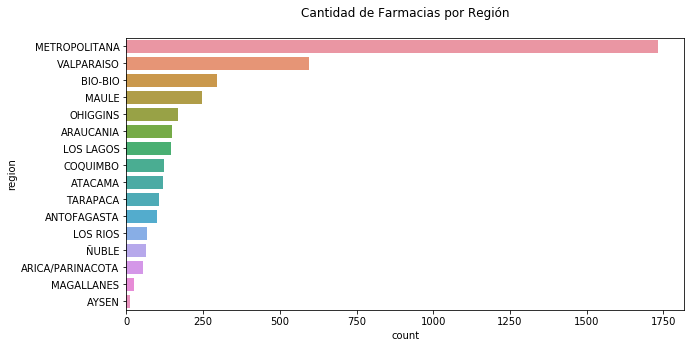

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(y=farmacia['region'],data=farmacia, order=farmacia['region'].value_counts().index)
plt.title("Cantidad de Farmacias por Región\n");

#### Cantidad de farmacias por comuna en la Región Metropolitana.

In [13]:
# Dataframe con datos de la Región Metropolitana.
farmacia_rm=farmacia[farmacia['region']=='METROPOLITANA']

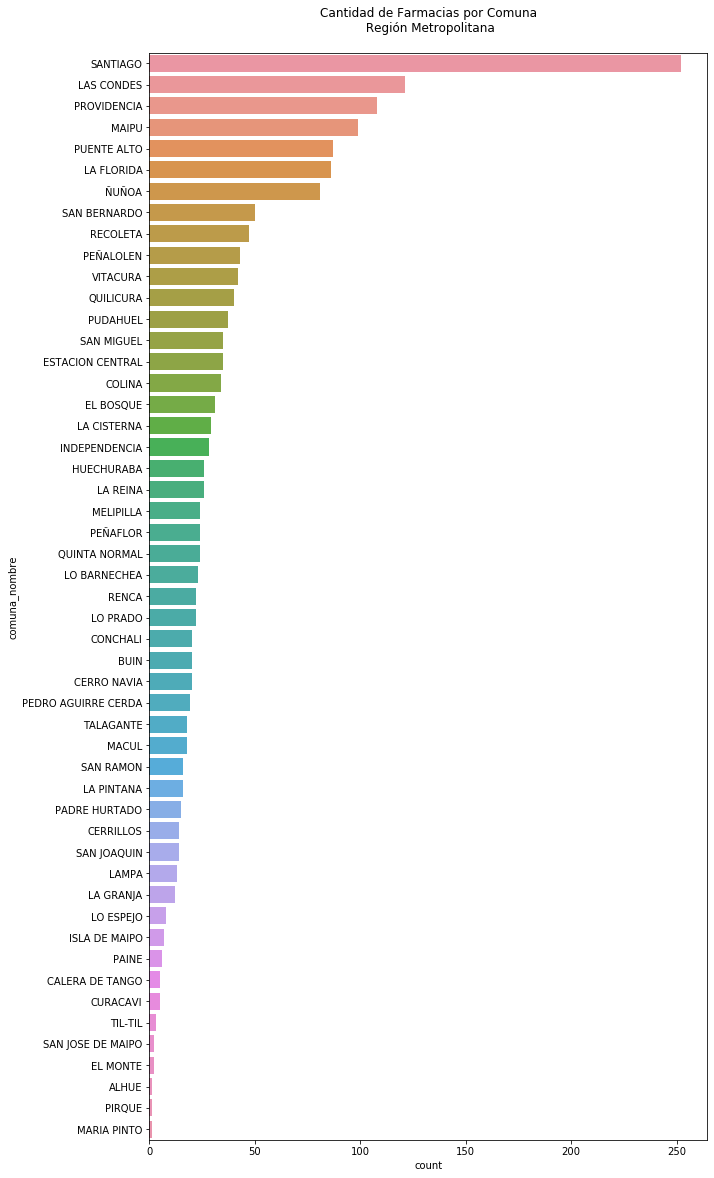

In [14]:
plt.figure(figsize=(10,20))
sns.countplot(y=farmacia_rm['comuna_nombre'],data=farmacia_rm, order=farmacia_rm['comuna_nombre'].value_counts().index)
plt.title("Cantidad de Farmacias por Comuna\n Región Metropolitana\n");

### 3. Despliegue del mapa de la Región Metropolitana.

Los archivos con los mapas vectoriales necesarios para desplegar el mapa de Chile, a nivel de comunas, se encuentran disponibles en el sitio de la Biblioteca del Congreso Nacional de Chile https://www.bcn.cl/siit/mapas_vectoriales en el ícono "División comunal: polígonos de las comunas de Chile".

In [15]:
# Carga de mapa vectorial.
chile = gpd.read_file("comunas.shp",encoding='utf-8')

In [16]:
chile.columns

Index(['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna',
       'codregion', 'st_area_sh', 'st_length_', 'Region', 'Comuna',
       'Provincia', 'geometry'],
      dtype='object')

In [17]:
# Eliminación de columnas que no se utilizarán.
chile=chile.drop(columns=['objectid', 'shape_leng', 'dis_elec', 'cir_sena', 'cod_comuna','codregion', 'st_area_sh', 'st_length_'])

In [18]:
chile.head()

,Region,Comuna,Provincia,geometry
0,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.7892 -4056669.318999998, -7..."
1,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,POLYGON ((-7831651.813300001 -4022443.10909999...
2,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.3574 -4060673.364100002, -7..."
3,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,POLYGON ((-7906457.717499999 -4051723.73449999...
4,Región de La Araucanía,Cholchol,Cautín,POLYGON ((-8121756.185699999 -4645860.29529999...


In [19]:
chile.crs

{'init': 'epsg:3857'}

In [20]:
# Ajuste de sistema de coordenadas.
chile = chile.to_crs({'init': 'epsg:4326'})

In [21]:
# Seleccion de datos de la Región Metropolitana.
metropolitana = chile[chile.Region == "Región Metropolitana de Santiago"].copy()
metropolitana.head()

,Region,Comuna,Provincia,geometry
26,Región Metropolitana de Santiago,San Joaquín,Santiago,POLYGON ((-70.62341581762824 -33.4733797392086...
36,Región Metropolitana de Santiago,San Miguel,Santiago,POLYGON ((-70.63659489246542 -33.5187285358260...
47,Región Metropolitana de Santiago,San Ramón,Santiago,POLYGON ((-70.63810714426249 -33.5186807630487...
57,Región Metropolitana de Santiago,Independencia,Santiago,POLYGON ((-70.6581665910322 -33.39914240465658...
61,Región Metropolitana de Santiago,La Cisterna,Santiago,POLYGON ((-70.65286194495638 -33.5476089756004...


In [22]:
metropolitana.shape

(52, 4)

In [23]:
# Ajuste de nombres de comunas (eliminar tildes).
metropolitana.replace({'San Ramón':'San Ramon', 'San José de Maipo':'San Jose de Maipo', 'Conchalí':'Conchali',
                       'Peñalolén':'Peñalolen','María Pinto':'Maria Pinto', 'San Joaquín':'San Joaquin','Maipú':'Maipu',
                       'Estación Central':'Estacion Central', 'Curacaví':'Curacavi', 'Alhué':'Alhue'}, inplace=True)

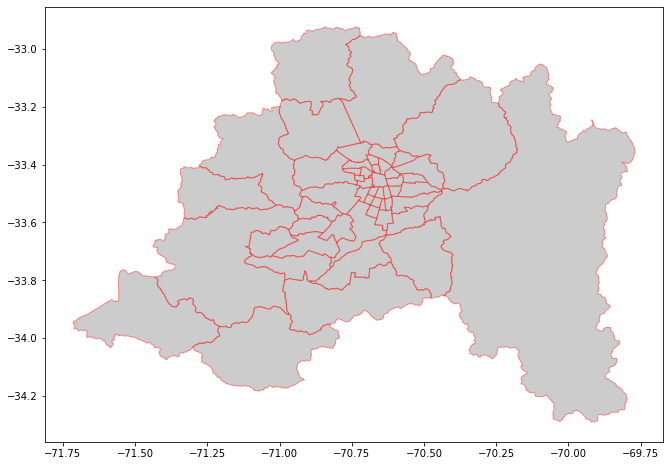

In [24]:
# Despliegue de mapa de la Región Metropolitana.
f, ax = plt.subplots(figsize=(25, 8))
metropolitana.plot(ax=ax,alpha = 0.4, color='grey',edgecolor='red')
plt.show()

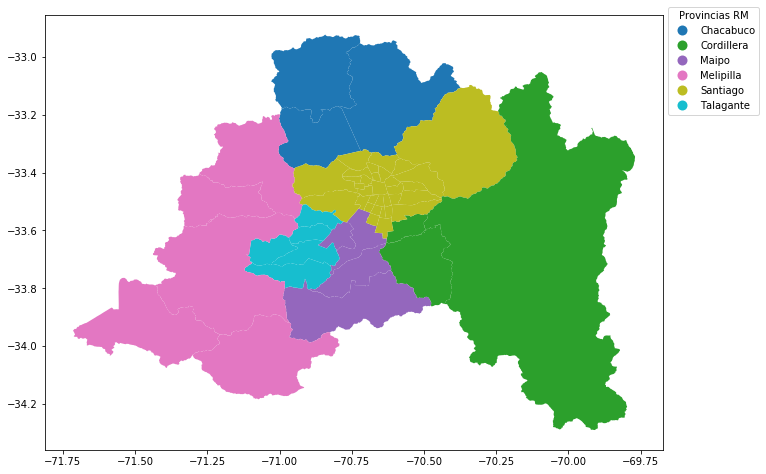

In [25]:
# Despliegue de mapa de la Región Metropolitana con detalle de Provincias.
f, ax = plt.subplots(1, figsize=(25, 8))
ax = metropolitana.plot(ax=ax,column="Provincia", legend=True, categorical=True,
                        legend_kwds = {'title': 'Provincias RM','loc': 'upper left',
                                       'bbox_to_anchor': (1, 1.03), 'ncol': 1, 'fancybox': 'True'})
plt.show()

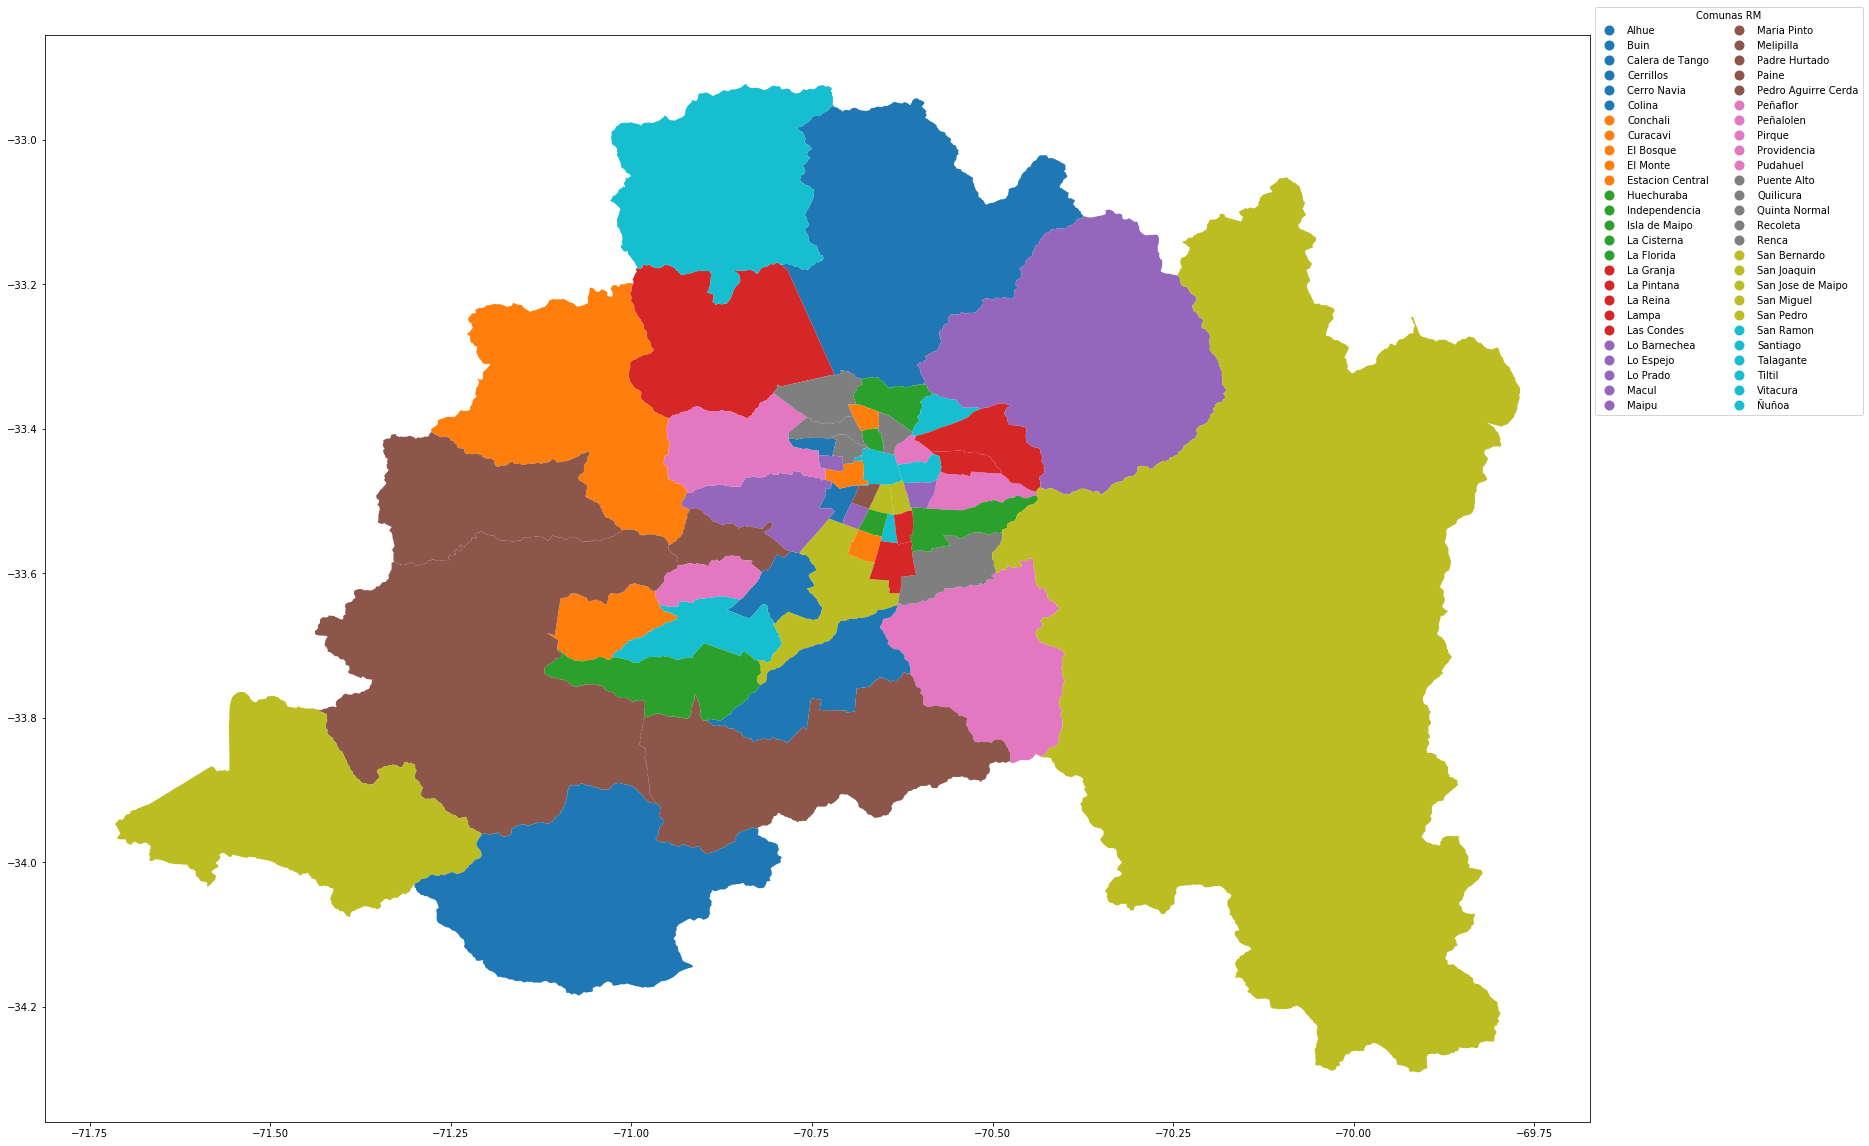

In [26]:
# Despliegue de mapa de la Región Metropolitana con detalle de comunas.
f, ax = plt.subplots(1, figsize=(30, 20))
ax = metropolitana.plot(ax=ax,column="Comuna", legend=True, categorical=True, 
                        legend_kwds = {'title': 'Comunas RM','loc': 'upper left',
                                       'bbox_to_anchor': (1, 1.03), 'ncol': 2,
                                       'fancybox': 'True'})
plt.show()

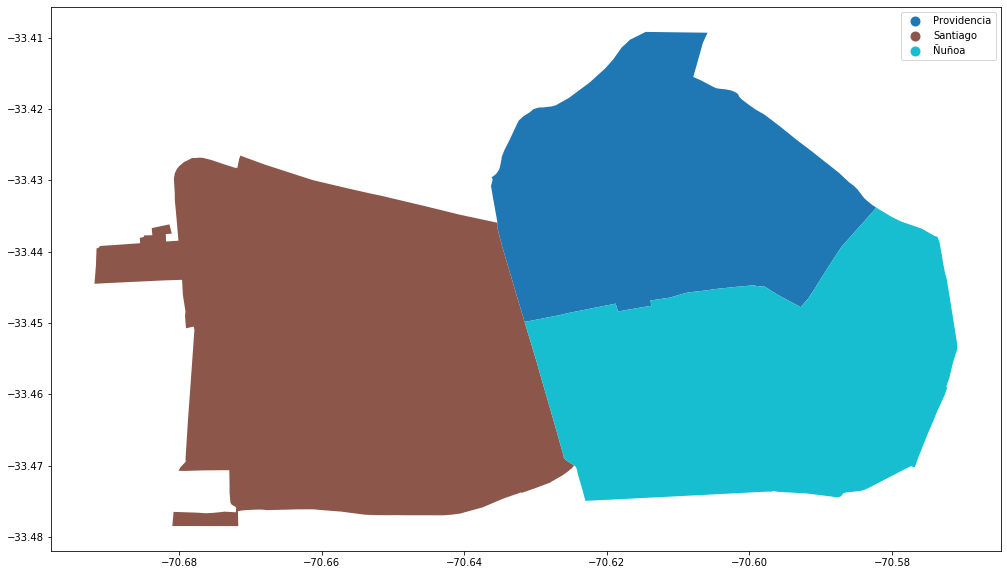

In [27]:
# Despliegue de mapa con comunas específicas de la Región Metropolitana.
f, ax = plt.subplots(1, figsize=(30, 10))
cm=metropolitana[metropolitana["Comuna"].isin(['Santiago','Providencia','Ñuñoa'])].plot(ax=ax,column="Comuna",legend=True,
                                                                                        categorical=True,
                                                                                        legend_kwds = {"loc": "upper right",
                                                                                                       "fancybox": "True"})
plt.show()

### 4. Limpieza de datos.

#### Identificación y eliminación de datos faltantes.

In [28]:
# Función para identificar datos faltantes.
def obs_perdidas(dataframe):
    tmp_colnames=[]
    tmp_na_count=[]
    tmp_porc=[]
    for colnames, serie in dataframe.iteritems():
        cant=serie.isna().value_counts().get(True)
        porc=serie.isna().value_counts('%').get(True)
        if cant is not None:
            tmp_colnames.append(colnames)
            tmp_na_count.append(cant)
            tmp_porc.append(round(porc*100,2))
            
    tmp_dataframe = pd.DataFrame(
                {'var': tmp_colnames,
                'perdidos': tmp_na_count,
                'porcentaje': tmp_porc})
    return tmp_dataframe.sort_values(by='perdidos', ascending=False)

In [29]:
# Identificación de datos faltantes.
obs_perdidas(farmacia_rm)

,var,perdidos,porcentaje
0,local_lat,116,6.7
1,local_lng,116,6.7


In [30]:
# Eliminación de datos faltantes.
farmacia_rm=farmacia_rm.dropna().reset_index(drop=True)

#### Identificación de outliers.

 #### Inspección visual de outliers usando boxplot.

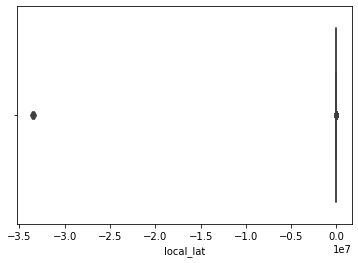

In [31]:
# Outliers latitud.
sns.boxplot(x=farmacia_rm['local_lat'])
plt.show()

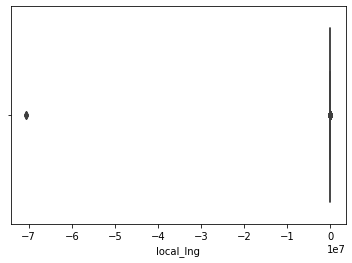

In [32]:
# Outliers longitud.
sns.boxplot(x=farmacia_rm['local_lng'])
plt.show()

#### Identificación outliers utilizando z score.
Se consideran outliers aquellas observaciones con valor absoluto de z score mayor a 3

In [33]:
# Función para identificar outliers.
def identify_outliers(df,column):
    serie=df[column]
    z = np.abs(stats.zscore(serie))
    outliers = serie[z > 3].to_list()
    return outliers

In [34]:
# Outliers latitud.
print(identify_outliers(farmacia_rm,'local_lat'))

[-33431624.0, -33593943.0, -33468548.0]


In [35]:
# Outliers longitud.
print(identify_outliers(farmacia_rm,'local_lng'))

[-70648996.0, -70660954.0, -70657935.0]


#### Eliminación outliers utilizando rango de coordenadas.

In [36]:
farmacia_rm = farmacia_rm[(farmacia_rm['local_lng'] < -67) & (farmacia_rm['local_lat'] < -32)]
farmacia_rm = farmacia_rm[(farmacia_rm['local_lng'] > -75) & (farmacia_rm['local_lat'] > -35)]
farmacia_rm=farmacia_rm.reset_index(drop=True)

### 5. Geolocalización de farmacias en mapa de la Región Metropolitana.

In [37]:
# Generación de GeoDataFrame.
geo1 = [Point(xy) for xy in zip(farmacia_rm["local_lng"],farmacia_rm["local_lat"])]
crs ={'init': 'epsg:4326'}
geo1_df = gpd.GeoDataFrame(farmacia_rm, crs=crs, geometry=geo1)
geo1_df.head()

,comuna_nombre,fk_comuna,region,local_lat,local_lng,local_nombre,geometry
0,RECOLETA,122,METROPOLITANA,-33.399635,-70.628950,TORRES MPD,POINT (-70.62894990000002 -33.3996351)
1,BUIN,83,METROPOLITANA,-33.732000,-70.735941,AHUMADA,POINT (-70.735941 -33.732)
2,BUIN,83,METROPOLITANA,-33.733602,-70.733803,AHUMADA,POINT (-70.73380300000001 -33.733602)
3,BUIN,83,METROPOLITANA,-33.729515,-70.739232,BUIN,POINT (-70.739232 -33.729515)
4,BUIN,83,METROPOLITANA,-33.733423,-70.737859,CRUZ VERDE,POINT (-70.737859 -33.73342299999999)


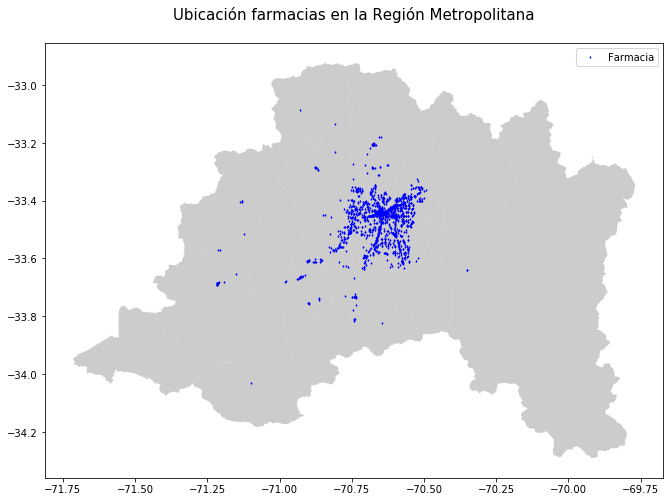

In [38]:
# Generación de mapa de la RM con puntos de ubicacion de farmacias.
f, ax = plt.subplots(figsize=(25, 8))
metropolitana.plot(ax=ax,alpha = 0.4, color='grey')
geo1_df.geometry.plot(marker='d', color='blue', markersize=1, ax=ax, label = 'Farmacia')
plt.title('Ubicación farmacias en la Región Metropolitana\n',fontdict = {'fontsize' : 15})
plt.legend()
plt.show();

### 6. Geolocalización de farmacias a nivel de comuna.

In [39]:
def geo_farmacia_comuna(comuna):
    geo_comuna_df = geo1_df[geo1_df['comuna_nombre']== comuna.upper()]
    f, ax = plt.subplots(figsize=(20, 8))
    metropolitana[metropolitana["Comuna"].isin([comuna])].plot(ax=ax,column="Comuna",legend=True, color='blue',
                                             edgecolor='black',categorical=True, 
                                             legend_kwds = {"loc": "lower right", "fancybox": "True"})
    geo_comuna_df.geometry.plot(marker="*", color='yellow', markersize=25, ax=ax)
    plt.title('Ubicación Farmacias\n en Comuna de {}\n'.format(comuna),fontdict = {'fontsize' : 15})
    plt.show();    

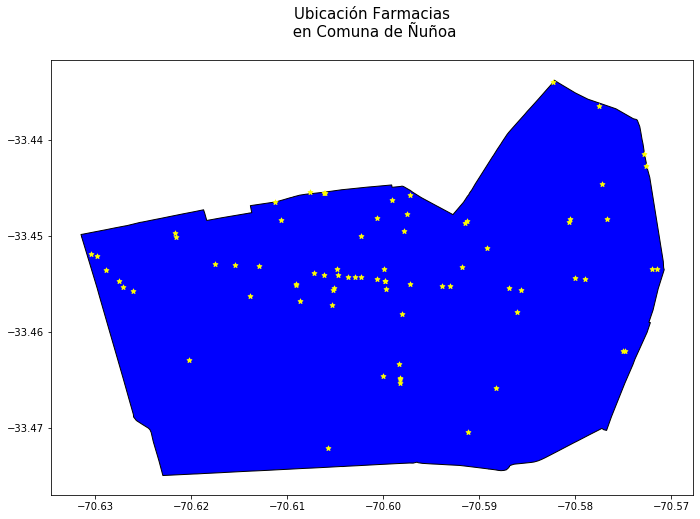

In [40]:
# Mapa de Ñuñoa con puntos de ubicacion de farmacias.
geo_farmacia_comuna('Ñuñoa')

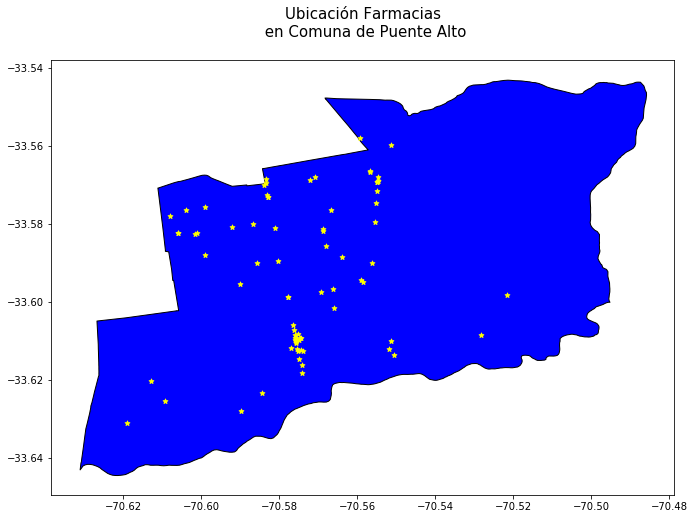

In [41]:
# Mapa de Puente Alto con puntos de ubicacion de farmacias.
geo_farmacia_comuna('Puente Alto')

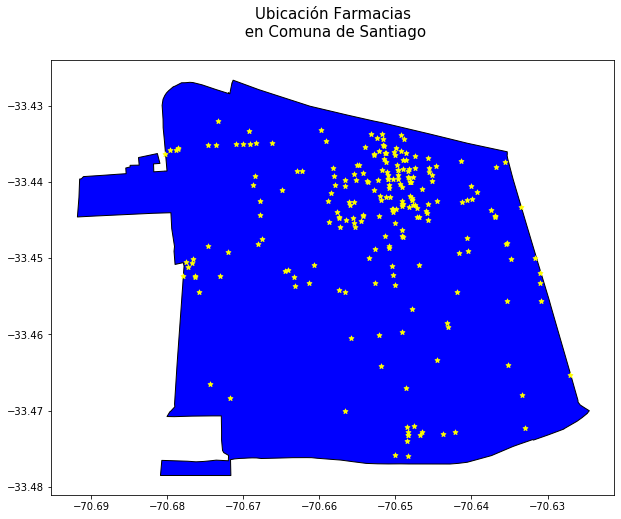

In [42]:
# Mapa de Santiago con puntos de ubicacion de farmacias.
geo_farmacia_comuna('Santiago')

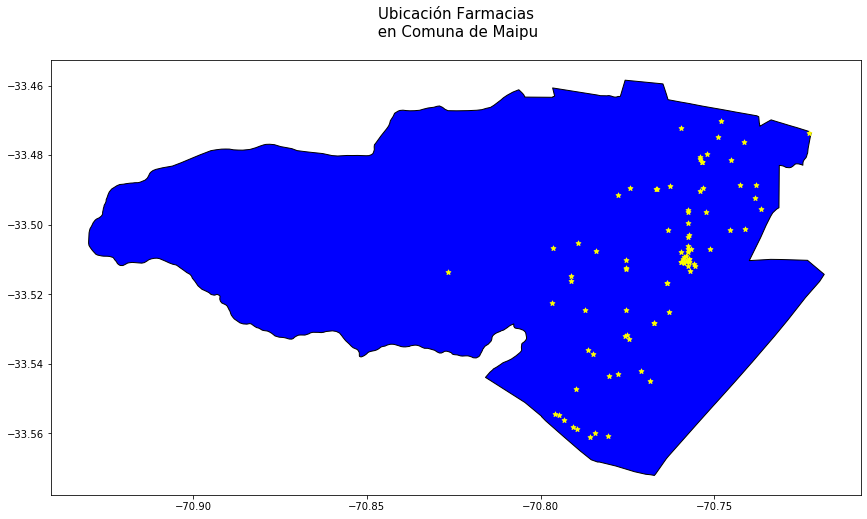

In [43]:
# Mapa de Maipu con puntos de ubicacion de farmacias.
geo_farmacia_comuna('Maipu')

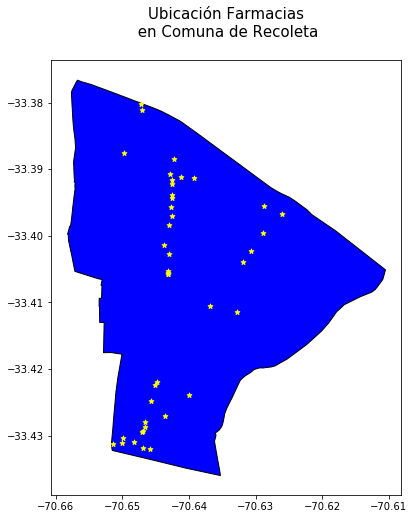

In [44]:
# Mapa de Recoleta con puntos de ubicacion de farmacias.
geo_farmacia_comuna('Recoleta')

### 7. Mapa cloropético usando cantidad de farmacias por comuna.

In [45]:
farmacia_rm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 7 columns):
comuna_nombre    1609 non-null object
fk_comuna        1609 non-null object
region           1609 non-null object
local_lat        1609 non-null float64
local_lng        1609 non-null float64
local_nombre     1609 non-null object
geometry         1609 non-null object
dtypes: float64(2), object(5)
memory usage: 88.1+ KB


In [46]:
# Generación DataFrame con cantidad de farmacias por comuna.
farmacia_comuna=farmacia_rm.groupby(by='comuna_nombre', as_index=False)['fk_comuna'].count()

In [47]:
farmacia_comuna.rename(columns={'comuna_nombre':'Comuna', 'fk_comuna':'Farmacias'}, inplace=True)

In [48]:
# Comunas de la RM ordenadas por cantidad de farmacias.
farmacia_comuna.sort_values(by='Farmacias', ascending=False).head(10)

,Comuna,Farmacias
46,SANTIAGO,226
20,LAS CONDES,114
34,PROVIDENCIA,97
25,MAIPU,89
15,LA FLORIDA,82
36,PUENTE ALTO,78
50,ÑUÑOA,75
41,SAN BERNARDO,47
32,PEÑALOLEN,42
39,RECOLETA,42


In [49]:
farmacia_comuna.replace({'TIL-TIL':'TILTIL'}, inplace=True)

In [50]:
# Conversión a mayúsculas de nombres de comunas.
metropolitana['Comuna']=metropolitana['Comuna'].apply(lambda x: x.upper())

In [51]:
# Generación de nuevo GeoDataFrame (que incluye cantidad de farmacias por comuna).
farmacias_geo_comuna = pd.merge(metropolitana, farmacia_comuna, on = 'Comuna')

In [52]:
farmacias_geo_comuna.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 5 columns):
Region       51 non-null object
Comuna       51 non-null object
Provincia    51 non-null object
geometry     51 non-null object
Farmacias    51 non-null int64
dtypes: int64(1), object(4)
memory usage: 2.4+ KB


In [53]:
farmacias_geo_comuna.head()

,Region,Comuna,Provincia,geometry,Farmacias
0,Región Metropolitana de Santiago,SAN JOAQUIN,Santiago,POLYGON ((-70.62341581762824 -33.4733797392086...,14
1,Región Metropolitana de Santiago,SAN MIGUEL,Santiago,POLYGON ((-70.63659489246542 -33.5187285358260...,31
2,Región Metropolitana de Santiago,SAN RAMON,Santiago,POLYGON ((-70.63810714426249 -33.5186807630487...,15
3,Región Metropolitana de Santiago,INDEPENDENCIA,Santiago,POLYGON ((-70.6581665910322 -33.39914240465658...,25
4,Región Metropolitana de Santiago,LA CISTERNA,Santiago,POLYGON ((-70.65286194495638 -33.5476089756004...,28


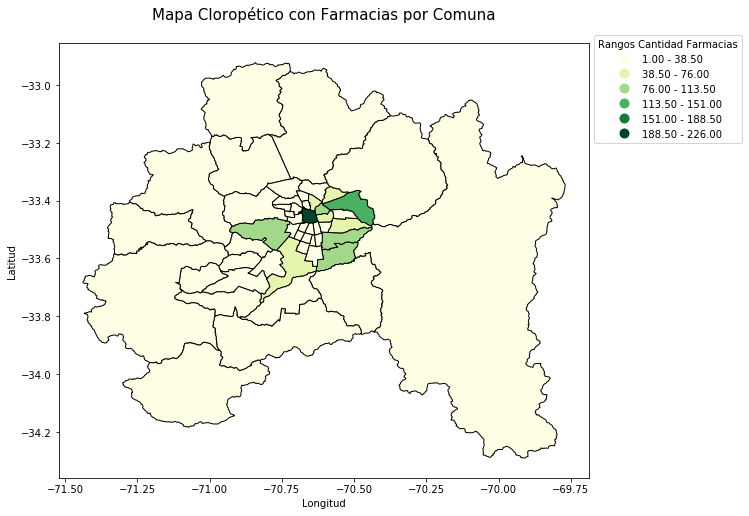

In [54]:
# Generación de mapa cloropético con cantidad de farmacias por comuna.
f, ax = plt.subplots(1, figsize=(25, 8))
ax=farmacias_geo_comuna.plot(ax=ax, column = 'Farmacias', scheme='equal_interval', k=6, cmap = 'YlGn', edgecolor = 'black', 
                             legend = True, legend_kwds = {'title': 'Rangos Cantidad Farmacias','loc': 'upper left',
                                                           'bbox_to_anchor': (1, 1.03),'ncol': 1,'fancybox': 'True'})
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Mapa Cloropético con Farmacias por Comuna\n',fontdict = {'fontsize' : 15})
plt.show();